# **Model Development - Bhopal Data - 90 Days**
by: Argish Abhangi

`Model info:` **120 Days** Prior data input ➡ lstm_model ➡ **90 days** ahead prediction output

Model - `MPIMO LSTM` (Multiple Parallel Input & Multiple Output) <br>
Trainig Metrics used - `MSE` <br> 
Optimizer used - `Adam` 

#### Importing Libraries

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

In [2]:
# Load the new datasets for Bhopal city
train_data_path = '../data/train_bhopal_final.csv'
test_data_path = '../data/test_bhopal_final.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

train_data.head()

,date,temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface,ACond_tavg,AvgSurfT_tavg,...,Qs_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg,precipitation_sum,Water_availability
0,2015-04-01,31.381519,0.005640,19.084161,4.671449,-0.277626,19.053919,0.0,0.009535,301.828791,...,0.000000e+00,301.828791,1153.966420,275.946408,4.782809,223.362352,6.349899e-07,1153.966582,0.0,-112.673746
1,2015-04-02,31.612318,0.006702,22.664057,5.663895,-0.951907,19.920647,0.0,0.011490,302.765242,...,0.000000e+00,302.765242,1151.749923,274.617967,4.659694,221.923497,4.469356e-07,1151.749969,0.0,-111.269587
2,2015-04-03,30.854070,0.006804,23.969701,5.704286,-0.857162,19.664423,0.0,0.012793,303.068777,...,0.000000e+00,303.068777,1149.649158,273.428841,4.484641,218.171090,3.210499e-07,1149.649124,0.0,-106.525412
3,2015-04-04,30.046127,0.008165,30.080859,2.575579,-1.547093,24.770628,0.0,0.014474,302.893081,...,0.000000e+00,302.893081,1147.826225,272.525414,4.354961,217.789598,2.082960e-07,1147.826188,0.0,-90.917171
4,2015-04-05,30.523074,0.007366,26.557658,-0.549178,-0.442961,23.765168,0.0,0.010641,302.875925,...,1.183570e-09,302.875925,1146.413800,272.040991,4.340641,175.870913,1.475418e-07,1146.414677,0.0,-82.613718


In [3]:
train_data.columns 

Index(['date', 'temperature_2m_above_ground',
       'specific_humidity_2m_above_ground',
       'relative_humidity_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground',
       'precipitable_water_entire_atmosphere', 'total_precipitation_surface',
       'ACond_tavg', 'AvgSurfT_tavg', 'CanopInt_tavg', 'ECanop_tavg',
       'ESoil_tavg', 'Evap_tavg', 'GWS_tavg', 'Lwnet_tavg', 'Qg_tavg',
       'Qh_tavg', 'Qle_tavg', 'Qs_tavg', 'SnowT_tavg', 'SoilMoist_P_tavg',
       'SoilMoist_RZ_tavg', 'SoilMoist_S_tavg', 'Swnet_tavg', 'TVeg_tavg',
       'TWS_tavg', 'precipitation_sum', 'Water_availability'],
      dtype='object')

In [4]:
len(train_data.columns)

29

#### Data Transformation and Normalization

In [5]:
# Convert 'date' to datetime and set as index (assuming similar structure as the Algiers dataset)
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])
train_data.set_index('date', inplace=True)
test_data.set_index('date', inplace=True)

# Check for missing values
missing_values_train_data = train_data.isnull().sum()
missing_values_test_data = test_data.isnull().sum()

# Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# Convert scaled data back to DataFrame for easier handling
train_scaled_df = pd.DataFrame(train_scaled, columns=train_data.columns, index=train_data.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test_data.columns, index=test_data.index)

In [6]:
def create_dataset(X, y, time_steps_in=1, time_steps_out=1):
    """
    Create a dataset for LSTM with specified number of input and output time steps.
    
    :param X: Input features
    :param y: Target feature
    :param time_steps_in: Number of time steps to use as input
    :param time_steps_out: Number of time steps to predict
    :return: reshaped input and output for LSTM model
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps_in - time_steps_out + 1):
        v = X.iloc[i:(i + time_steps_in)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps_in:i + time_steps_in + time_steps_out].values)
    
    return np.array(Xs), np.array(ys)

# Number of time steps for input and output
time_steps_in, time_steps_out = 120, 90

X_train, y_train = create_dataset(train_scaled_df.drop('Water_availability', axis=1), train_scaled_df['Water_availability'], time_steps_in, time_steps_out)
X_test, y_test = create_dataset(test_scaled_df.drop('Water_availability', axis=1), test_scaled_df['Water_availability'], time_steps_in, time_steps_out)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2213, 120, 27), (2213, 90), (336, 120, 27), (336, 90))

### **Model Training**

In [7]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(device)
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_layer_size)
        out = self.linear(hn)
        return out

# Model parameters
input_size = 27  # Number of features
hidden_layer_size = 65
output_size = time_steps_out

# Instantiate the model
model = LSTMModel(input_size, hidden_layer_size, output_size)
model.to(device)

model

LSTMModel(
  (lstm): LSTM(27, 65, batch_first=True)
  (linear): Linear(in_features=65, out_features=90, bias=True)
)

In [9]:
# Training parameters
learning_rate = 0.0001
num_epochs = 400 

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [10]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# UnComment to save the weights
# torch.save(model.state_dict(), './trained_model/Bhopal_90_Days.pt')

"Model training complete and model saved."

Epoch [10/400], Loss: 0.0940
Epoch [20/400], Loss: 0.0891
Epoch [30/400], Loss: 0.0839
Epoch [40/400], Loss: 0.0783
Epoch [50/400], Loss: 0.0719
Epoch [60/400], Loss: 0.0645
Epoch [70/400], Loss: 0.0560
Epoch [80/400], Loss: 0.0467
Epoch [90/400], Loss: 0.0371
Epoch [100/400], Loss: 0.0284
Epoch [110/400], Loss: 0.0215
Epoch [120/400], Loss: 0.0161
Epoch [130/400], Loss: 0.0119
Epoch [140/400], Loss: 0.0088
Epoch [150/400], Loss: 0.0065
Epoch [160/400], Loss: 0.0048
Epoch [170/400], Loss: 0.0036
Epoch [180/400], Loss: 0.0028
Epoch [190/400], Loss: 0.0022
Epoch [200/400], Loss: 0.0018
Epoch [210/400], Loss: 0.0016
Epoch [220/400], Loss: 0.0015
Epoch [230/400], Loss: 0.0014
Epoch [240/400], Loss: 0.0013
Epoch [250/400], Loss: 0.0013
Epoch [260/400], Loss: 0.0012
Epoch [270/400], Loss: 0.0012
Epoch [280/400], Loss: 0.0012
Epoch [290/400], Loss: 0.0012
Epoch [300/400], Loss: 0.0011
Epoch [310/400], Loss: 0.0011
Epoch [320/400], Loss: 0.0011
Epoch [330/400], Loss: 0.0011
Epoch [340/400], Lo

'Model training complete and model saved.'

### **Evaluating the model**

In [11]:
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)

test_loss.item()

0.0016668953467160463

#### Metrics before inverse transform

In [12]:
test_predictions_np = test_predictions.detach().cpu().numpy()

mse = mean_squared_error(y_test, test_predictions_np)
rmse = root_mean_squared_error(y_test, test_predictions_np)
mae = mean_absolute_error(y_test, test_predictions_np)

print(f"mse: {mse:.4f}")
print(f"mae: {mae:.4f}")
print(f"rmse: {rmse:.4f}")

mse: 0.0017
mae: 0.0206
rmse: 0.0408


#### Inverse Transforming predictions and y_test

In [13]:
num_features = train_data.shape[1] 

last_step_predictions = test_predictions.detach().cpu().numpy()[:, -1]
dummies = np.zeros((last_step_predictions.shape[0], num_features))
dummies[:, -1] = last_step_predictions
dummies_transformed = scaler.inverse_transform(dummies)
inverse_transformed_test_predictions = dummies_transformed[:, -1]

y_test_last_step = y_test[:, -1]
y_test_dummies = np.zeros((y_test.shape[0], num_features))
y_test_dummies[:, -1] = y_test_last_step
y_test_dummies_transformed = scaler.inverse_transform(y_test_dummies)
inverse_transformed_y_test = y_test_dummies_transformed[:, -1]


####  Visualizing the results

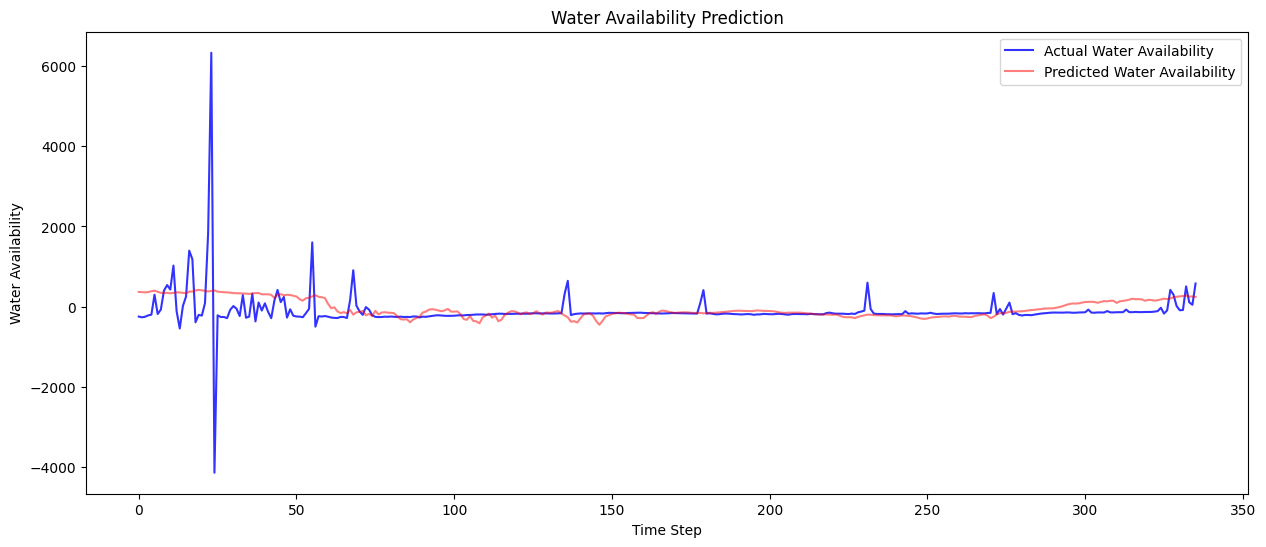

In [14]:
plt.figure(figsize=(15, 6))
plt.plot(inverse_transformed_y_test, label='Actual Water Availability', color='blue', alpha=0.8)  # Use inverse transformed data
plt.plot(inverse_transformed_test_predictions, label='Predicted Water Availability', color='red', alpha=0.5)
plt.title('Water Availability Prediction')
plt.xlabel('Time Step')
plt.ylabel('Water Availability')
plt.legend()
plt.show()

#### Metrics after inverse transform

In [15]:
mse = mean_squared_error(inverse_transformed_y_test, inverse_transformed_test_predictions)
rmse = root_mean_squared_error(inverse_transformed_y_test, inverse_transformed_test_predictions)
mae = mean_absolute_error(inverse_transformed_y_test, inverse_transformed_test_predictions)

print(f"mse: {mse:.4f}")
print(f"mae: {mae:.4f}")
print(f"rmse: {rmse:.4f}")

mse: 247091.0513
mae: 212.8978
rmse: 497.0825
